In [31]:
import numpy as np
train = np.loadtxt('Assignment1.2/train2.csv', delimiter=',', skiprows=1)
feature_name = np.loadtxt('Assignment1.2/train2.csv', delimiter=',', max_rows=1, dtype=str)
feature_name = [str(name) for name in feature_name]
for i in range(len(feature_name)):
    print(f"{i+1}  {feature_name[i]}")

1  Hospital Service Area
2  Hospital County
3  Operating Certificate Number
4  Permanent Facility Id
5  Facility Name
6  Age Group
7  Zip Code - 3 digits
8  Total Costs
9  Race
10  Ethnicity
11  Length of Stay
12  Type of Admission
13  Patient Disposition
14  CCSR Diagnosis Code
15  CCSR Procedure Code
16  APR DRG Code
17  APR MDC Code
18  APR Severity of Illness Description
19  APR Risk of Mortality
20  APR Medical Surgical Description
21  Payment Typology 1
22  Payment Typology 2
23  Payment Typology 3
24  Birth Weight
25  Emergency Department Indicator
26  Gender


In [32]:
X = train[:, :-1]
Y = train[:, -1]
X_test = np.loadtxt('Assignment1.2/test2.csv', delimiter=',', skiprows=1)
Y_test = np.loadtxt('Assignment1.2/test_pred2.csv', delimiter=',', skiprows=1)

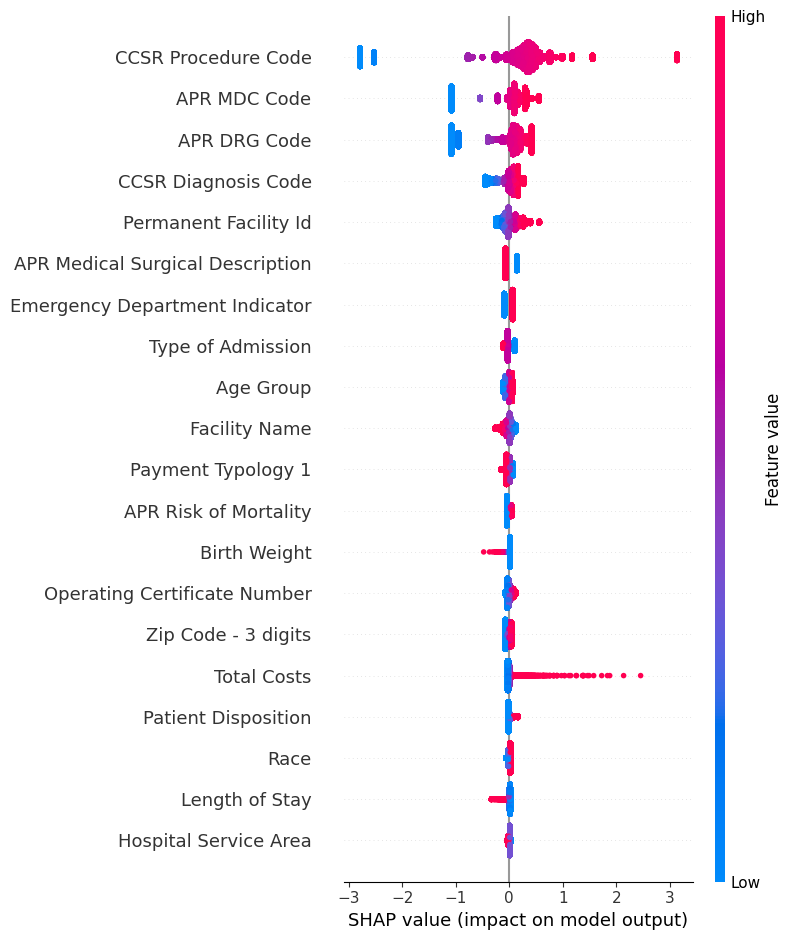

In [37]:
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

cat_ind=[0,1,2,3,4,5,6,8,9,11,12,13,14,15,16,17,18,19,20,21,22,24]
# def encode(X,y,cat_ind):
#     X_encoded = np.copy(X)
#     for idx in cat_ind:
#         unique_values = np.unique(X[:, idx])
#         mean_target = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
#         encoding_map = dict(zip(unique_values, mean_target))
#         X_encoded[:, idx] = np.array([encoding_map[value] for value in X[:, idx]])
    
#     return X_encoded

# def compute_target_encoding(X, y, cat_ind):
#     encoding_maps = {}
#     for idx in cat_ind:
#         unique_values = np.unique(X[:, idx])
#         mean_target = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
#         encoding_maps[idx] = dict(zip(unique_values, mean_target))
#     return encoding_maps

def compute_target_encoding(X, y, cat_ind, alpha=1000):
    encoding_maps = {}
    global_mean = np.mean(y)
    for idx in cat_ind:
        unique_values = np.unique(X[:, idx])
        category_means = np.array([np.mean(y[X[:, idx] == value]) for value in unique_values])
        category_counts = np.array([np.sum(X[:, idx] == value) for value in unique_values])
        
        # Apply smoothing
        smoothed_means = (category_means * category_counts + global_mean * alpha) / (category_counts + alpha)
        encoding_maps[idx] = dict(zip(unique_values, smoothed_means))
    
    return encoding_maps

def apply_target_encoding(X, encoding_maps):
    X_encoded = np.copy(X)
    for idx, encoding_map in encoding_maps.items():
        X_encoded[:, idx] = np.array([encoding_map.get(value, 0) for value in X[:, idx]])
    return X_encoded

enc= compute_target_encoding(X,Y,cat_ind)
X_shap= apply_target_encoding(X,enc)
scaler = StandardScaler()
X_shap= scaler.fit_transform(X_shap)
model = LogisticRegression().fit(X_shap, Y)

# X_test= apply_target_encoding(X_test,enc)
# X_test= scaler.transform(X_test)

explainer = shap.LinearExplainer(model, X_shap)
shap_values = explainer.shap_values(X_shap)

shap.summary_plot(shap_values, X_shap, feature_names=feature_name)


In [17]:
from sklearn.feature_selection import f_classif
F_values, p_values = f_classif(X, Y)
print("F-values:", F_values)
print("P-values:", p_values)

F-values: [1.69322957e+00 3.91403967e-01 7.53088385e+00 5.57683899e+00
 1.59571766e+00 1.16415072e+02 1.95497728e+00 2.85440515e+02
 1.70824814e+01 3.84575327e+00 4.05966311e+02 1.18865323e-01
 6.48723065e+01 2.64718511e+03 7.34386628e+02 2.69677980e+02
 3.05278528e+02 4.57407466e+02 2.94216252e+02 1.80948686e+02
 1.33756581e+01 1.72142186e+01 8.24056161e+00 8.63433715e+02
 7.21269101e+02]
P-values: [1.93179210e-001 5.31563969e-001 6.06624918e-003 1.82017188e-002
 2.06514500e-001 4.00996915e-027 1.62055050e-001 6.18773572e-064
 3.58241763e-005 4.98752785e-002 4.43430474e-090 7.30269239e-001
 8.09072070e-016 0.00000000e+000 4.62340068e-161 1.64331140e-060
 3.04645475e-068 3.20361684e-101 7.68563911e-066 3.30569560e-041
 2.55060377e-004 3.34242417e-005 4.09742660e-003 7.26545707e-189
 3.11740975e-158]


In [19]:
features_with_pvalues = list(zip(feature_name, p_values))
sorted_features = sorted(features_with_pvalues, key=lambda x: x[1], reverse=False)
sorted_feature_names, sorted_p_values = zip(*sorted_features)
for name, p_value in zip(sorted_feature_names, sorted_p_values):
    print(f"{name.ljust(35)} | {p_value:.4f}".rjust(20))

CCSR Diagnosis Code                 | 0.0000
Birth Weight                        | 0.0000
CCSR Procedure Code                 | 0.0000
Emergency Department Indicator      | 0.0000
APR Severity of Illness Description | 0.0000
Length of Stay                      | 0.0000
APR MDC Code                        | 0.0000
APR Risk of Mortality               | 0.0000
Total Costs                         | 0.0000
APR DRG Code                        | 0.0000
APR Medical Surgical Description    | 0.0000
Age Group                           | 0.0000
Patient Disposition                 | 0.0000
Payment Typology 2                  | 0.0000
Race                                | 0.0000
Payment Typology 1                  | 0.0003
Payment Typology 3                  | 0.0041
Operating Certificate Number        | 0.0061
Permanent Facility Id               | 0.0182
Ethnicity                           | 0.0499
Zip Code - 3 digits                 | 0.1621
Hospital Service Area               | 0.1932
Facility N

In [20]:
features_with_fvalues = list(zip(feature_name, F_values))
sorted_features = sorted(features_with_fvalues, key=lambda x: x[1], reverse=True)
sorted_feature_names, sorted_f_values = zip(*sorted_features)
for name, f_value in zip(sorted_feature_names, sorted_f_values):
    print(f"{name.ljust(35)} | {f_value:.4f}".rjust(20))

CCSR Diagnosis Code                 | 2647.1851
Birth Weight                        | 863.4337
CCSR Procedure Code                 | 734.3866
Emergency Department Indicator      | 721.2691
APR Severity of Illness Description | 457.4075
Length of Stay                      | 405.9663
APR MDC Code                        | 305.2785
APR Risk of Mortality               | 294.2163
Total Costs                         | 285.4405
APR DRG Code                        | 269.6780
APR Medical Surgical Description    | 180.9487
Age Group                           | 116.4151
Patient Disposition                 | 64.8723
Payment Typology 2                  | 17.2142
Race                                | 17.0825
Payment Typology 1                  | 13.3757
Payment Typology 3                  | 8.2406
Operating Certificate Number        | 7.5309
Permanent Facility Id               | 5.5768
Ethnicity                           | 3.8458
Zip Code - 3 digits                 | 1.9550
Hospital Service Area     

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features including interaction terms
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X_interaction = poly.fit_transform(X)
interaction_feature_names = []

# Add interaction names
n= len(feature_name)
for i in range(n):
    interaction_feature_names.append(feature_name[i])

for i in range(n):
    for j in range(i + 1, n):
        interaction_feature_names.append(f"{feature_name[i]} * {feature_name[j]}")

from sklearn.feature_selection import f_classif

# Apply ANOVA to interaction terms
_, p_values = f_classif(X_interaction, Y)

# Select features based on p-values
significant_features = np.where(p_values < 0.05)[0]  # Example threshold
interaction_feature_names = [str(name) for name in interaction_feature_names]

In [ ]:
# for index in significant_features:
#     print(interaction_feature_names[index])

In [ ]:
print(len(significant_features))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Fit the logistic regression model with L1 penalty
model = LogisticRegression(penalty='l1', solver='liblinear')
model.fit(X, Y)

# Select features based on coefficients
selector = SelectFromModel(model, prefit=True)
X_train_selected = selector.transform(X)

# Check the selected features
selected_features = selector.get_support(indices=True)
print(selected_features)
print(len(selected_features))
for index in selected_features:
    print(feature_name[index])
